In [3]:
# se instalan las librerías
!pip install ucimlrepo

In [4]:
# se carga la data
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_failure_clinical_records = fetch_ucirepo(id=519)

# data (as pandas dataframes)
X = heart_failure_clinical_records.data.features
y = heart_failure_clinical_records.data.targets

print("X:")
print(X)
print("y:")
print(y)

X:
      age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0        0                       582         0                 20   
1    55.0        0                      7861         0                 38   
2    65.0        0                       146         0                 20   
3    50.0        1                       111         0                 20   
4    65.0        1                       160         1                 20   
..    ...      ...                       ...       ...                ...   
294  62.0        0                        61         1                 38   
295  55.0        0                      1820         0                 38   
296  45.0        0                      2060         1                 60   
297  45.0        0                      2413         0                 38   
298  50.0        0                       196         0                 45   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex

In [5]:
# prompt: Se obtienen las columnas con mayor correlación del dataframe X con el dataframe y

import pandas as pd

# Calculate the correlation matrix between X and y
correlation_matrix = pd.concat([X, y], axis=1).corr()

# Get the correlation of each feature with the target variable
target_correlations = correlation_matrix[y.columns[0]]

# Remove the correlation of the target variable with itself
target_correlations = target_correlations.drop(y.columns[0])

# Sort the features by their absolute correlation with the target variable
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

# Print the top features with the highest correlation
print("Top features with the highest correlation with the target variable:")
print(sorted_correlations)

# You can select a certain number of top features with the highest correlation
# For example, to get the top 5 features:
top_features = sorted_correlations.head(5).index.tolist()
print("\nTop 5 features:")
print(top_features)

Top features with the highest correlation with the target variable:
time                        0.526964
serum_creatinine            0.294278
ejection_fraction           0.268603
age                         0.253729
serum_sodium                0.195204
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
platelets                   0.049139
smoking                     0.012623
sex                         0.004316
diabetes                    0.001943
Name: death_event, dtype: float64

Top 5 features:
['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium']


In [6]:
X = X[['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium']]

In [7]:
# se escalan las variables del dataframe X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-1.62950241,  0.49005699, -1.53055953,  1.19294523, -1.50403612],
       [-1.60369074, -0.28455235, -0.00707675, -0.49127928, -0.14197615],
       [-1.5907849 , -0.09090002, -1.53055953,  0.35083298, -1.73104612],
       ...,
       [ 1.90669738, -0.57503085,  1.85495776, -1.33339153,  0.31204384],
       [ 1.93250906,  0.00592615, -0.00707675, -1.33339153,  0.76606383],
       [ 1.99703825,  0.19957848,  0.58538877, -0.9123354 , -0.14197615]])

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=123)

In [26]:
# se crea el grid para evaluar los parámetros para el modelo MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes':[15, 25, 30, (10, 10, 10), (50, 100, 50)],
    #'activation': ['tanh', 'relu'],
    #'solver': ['sgd', 'adam'],
    'activation': ['tanh'],
    'solver': ['sgd'],
    'alpha': [0.0001, 0.25],
    #'learning_rate': ['constant','adaptive'],
}
grid = GridSearchCV(
        estimator = MLPClassifier(
                        learning_rate_init=0.01,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )
_ = grid.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed w

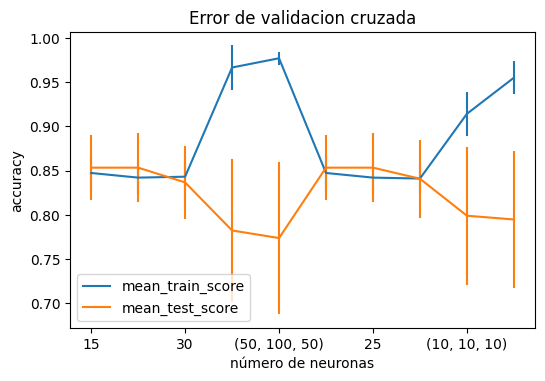

In [27]:
# se grafican los resultados:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_hidden_layer_sizes', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_hidden_layer_sizes', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_ylabel('accuracy')
ax.set_xlabel('número de neuronas')
ax.set_title('Error de validacion cruzada');

In [28]:
modelo = grid.best_estimator_
modelo

MLPClassifier(activation='tanh', hidden_layer_sizes=25, learning_rate_init=0.01,
              max_iter=5000, random_state=123, solver='sgd')

In [29]:
# se obtiene el score de modelo
modelo.score(x_test, y_test)

0.8333333333333334